In [11]:
import os
import glob
import datetime

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPooling3D, Reshape, Flatten, BatchNormalization, Dropout
from keras import callbacks

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# **LOAD DATA**

In [12]:
path = os.path.join('../data/paris_lille/npy_objects_method2/', '*.npy')

voxels_list = []
label_list = []

for npy_file in glob.iglob(path):
    
    file_name = npy_file.split('/')[-1].split('_')[0]
    label_list.append(file_name)
    
    voxels = np.load(npy_file).astype(np.float32)
    voxels_list.append(voxels)

In [13]:
object_classes = {
    '0' : 'Unclassified',
    '100000000' : 'Other',
    '200000000' : 'Surface',
    '201000000' : 'Other Surface',
    '202000000' : 'Ground',
    '202010000' : 'Other Ground',
    '202020000' : 'Road',
    '202030000' : 'Sidewalk',
    '202040000' : 'Curb',
    '202050000' : 'Island',
    '202060000' : 'Vegetation',
    '203000000' : 'Building',
    '300000000' : 'Object',
    '301000000' : 'Other Object',
    '302000000' : 'Static',
    '302010000' : 'Other Static',
    '302020000' : 'Punctual Object',
    '302020100' : 'Other Punctual Object',
    '302020200' : 'Post',
    '302020300' : 'Bollard',
    '302020400' : 'Floor Lamp',
    '302020500' : 'Traffic Light',
    '302020600' : 'Traffic Sign',
    '302020700' : 'Signboard',
    '302020800' : 'Mailbox',
    '302020900' : 'Trash Can',
    '302021000' : 'Meter',
    '302021100' : 'Bicycle Terminal',
    '302021200' : 'Bicycle Rack',
    '302021300' : 'Statue',
    '302030000' : 'Linear',
    '302030100' : 'Other Linear',
    '302030200' : 'Barrier',
    '302030300' : 'Roasting',
    '302030400' : 'Grid',
    '302030500' : 'Chain',
    '302030600' : 'Wire',
    '302030700' : 'Low Wall',
    '302040000' : 'Extended',
    '302040100' : 'Other Extended',
    '302040200' : 'Shelter',
    '302040300' : 'Kiosk',
    '302040400' : 'Scaffold',
    '302040500' : 'Bench',
    '302040600' : 'Distribution Box',
    '302040700' : 'Lighting Console',
    '302040800' : 'Windmill',
    '303000000' : 'Dynamic',
    '303010000' : 'Other Dynamic',
    '303020000' : 'Pedestrian',
    '303020100' : 'Other Pedestrian',
    '303020200' : 'Still Pedestrian',
    '303020300' : 'Walking Pedestrian',
    '303020400' : 'Running Pedestrian',
    '303020500' : 'Stroller Pedestrian',
    '303020600' : 'Holding Pedesterian',
    '303020700' : 'Leaning Pedestrian',
    '303020800' : 'Skater',
    '303020900' : 'Rollerskater',
    '303021000' : 'Wheelchair',
    '303030000' : '2 Wheelers',
    '303030100' : 'Other 2 Wheels',
    '303030200' : 'Bicycle',
    '303030201' : 'Other Bicycle',
    '303030202' : 'Mobile Bicycle',
    '303030203' : 'Stopped Bicycle',
    '303030204' : 'Parked Bicycle',
    '303030300' : 'Scooter',
    '303030301' : 'Other Scooter',
    '303030302' : 'Mobile Scooter',
    '303030303' : 'Stopped Scooter',
    '303030304' : 'Parked Scooter',
    '303030400' : 'Moped',
    '303030401' : 'Other Moped',
    '303030402' : 'Mobile Moped',
    '303030403' : 'Stopped Moped',
    '303030404' : 'Parked Moped',
    '303030500' : 'Motorbike',
    '303030501' : 'Other Motorbike',
    '303030502' : 'Mobile Motorbike',
    '303030503' : 'Stopped Motorbike',
    '303030504' : 'Parked Motorbike',
    '303040000' : '4+ Wheelers',
    '303040100' : 'Other 4+ Wheelers',
    '303040200' : 'Car',
    '303040201' : 'Other Car',
    '303040202' : 'Mobile Car',
    '303040203' : 'Stopped Car',
    '303040204' : 'Parked Car',
    '303040300' : 'Van',
    '303040301' : 'Other Van',
    '303040302' : 'Mobile Van',
    '303040303' : 'Stopped Van',
    '303040304' : 'Parked Van',
    '303040400' : 'Truck',
    '303040401' : 'Other Truck',
    '303040402' : 'Mobile Truck',
    '303040403' : 'Stopped Truck',
    '303040404' : 'Parked Truck',
    '303040500' : 'Bus',
    '303040501' : 'Other Bus',
    '303040502' : 'Mobile Bus',
    '303040503' : 'Stopped Bus',
    '303040504' : 'Parked Bus',
    '303050000' : 'Furniture',
    '303050100' : 'Other Furniture',
    '303050200' : 'Table',
    '303050300' : 'Chair',
    '303050400' : 'Stool',
    '303050500' : 'Trash Can',
    '303050600' : 'Waste',
    '304000000' : 'Natural',
    '304010000' : 'Other Natural',
    '304020000' : 'Tree',
    '304030000' : 'Bush',
    '304040000' : 'Potted Plant',
    '304050000' : 'Hedge'
}

In [14]:
labels = [object_classes.get(item,item) for item in label_list]
unique_labels = np.unique(labels)

mapping = {}
keys = range(len(unique_labels))

for i in keys:
    mapping[i] = unique_labels[i]
    
rev_mapping = dict((v,k) for k,v in mapping.items())
new_labels = [rev_mapping[i] for i in labels]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(voxels_list, new_labels, test_size=.33, random_state=0)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# **BUILD NET**

In [16]:
def _lrelu(x, alpha=0.1):
    """a leaky rectified nonlinearity unit (Leaky ReLU) with parameter alpha=0.1"""
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

In [24]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(5,5,5), strides=(2,2,2), activation=_lrelu, input_shape=(32,32,32,1)))
model.add(Conv3D(32, kernel_size=3, strides=1, activation=_lrelu))
model.add(MaxPooling3D(pool_size=2, strides=1))
model.add(Flatten())
model.add(Dense(128, activation=_lrelu))
model.add(Dense(np.unique(new_labels).shape[0], activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 14, 14, 14, 32)    4032      
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 12, 12, 12, 32)    27680     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 11, 11, 11, 32)    0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 42592)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               5451904   
_________________________________________________________________
dense_5 (Dense)              (None, 47)                6063      
Total params: 5,489,679
Trainable params: 5,489,679
Non-trainable params: 0
____________________________________________

# **INITIAL FITTING**

In [18]:
fit = model.fit(np.array(X_train).reshape(-1,32,32,32,1), np.array(y_train), batch_size=32, epochs=10, verbose=1)

Epoch 1/10
49/49 [==============================] - 118s 2s/step - loss: 2.6945 - accuracy: 0.3459
Epoch 2/10
49/49 [==============================] - 121s 2s/step - loss: 1.2022 - accuracy: 0.6752
Epoch 3/10
49/49 [==============================] - 118s 2s/step - loss: 0.5699 - accuracy: 0.8445
Epoch 4/10
49/49 [==============================] - 119s 2s/step - loss: 0.3109 - accuracy: 0.9147
Epoch 5/10
49/49 [==============================] - 118s 2s/step - loss: 0.1674 - accuracy: 0.9512
Epoch 6/10
49/49 [==============================] - 118s 2s/step - loss: 0.1264 - accuracy: 0.9627
Epoch 7/10
49/49 [==============================] - 123s 3s/step - loss: 0.0317 - accuracy: 0.9890
Epoch 8/10
49/49 [==============================] - 120s 2s/step - loss: 0.0261 - accuracy: 0.9915
Epoch 9/10
49/49 [==============================] - 122s 3s/step - loss: 0.0289 - accuracy: 0.9963
Epoch 10/10
49/49 [==============================] - 119s 2s/step - loss: 0.0188 - accuracy: 0.9941


In [19]:
pred = model.predict(np.array(X_test).reshape(-1,32,32,32,1))
pred = np.argmax(pred, axis=1)

In [20]:
print(f1_score(y_test, pred, average='macro'))
print(f1_score(y_test, pred, average='micro'))
print(f1_score(y_test, pred, average='weighted'))

0.5446140820458588
0.7441253263707572
0.7309408226538185


# **TUNE NUMBER OF EPOCHS**

In [21]:
X_val = X_train[:300]
y_val = y_train[:300]

X_train = X_train[300:]
y_train = y_train[300:]

In [22]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [25]:
fit = model.fit(np.array(X_train).reshape(-1,32,32,32,1), np.array(y_train), batch_size=32, epochs=20, validation_data=(np.array(X_val).reshape(-1,32,32,32,1),np.array(y_val)), callbacks=[earlystopping])

Epoch 1/20
40/40 [==============================] - 106s 3s/step - loss: 2.8456 - accuracy: 0.2837 - val_loss: 1.7300 - val_accuracy: 0.6000
Epoch 2/20
40/40 [==============================] - 100s 3s/step - loss: 1.3579 - accuracy: 0.6325 - val_loss: 1.4200 - val_accuracy: 0.6567
Epoch 3/20
40/40 [==============================] - 97s 2s/step - loss: 0.6845 - accuracy: 0.7979 - val_loss: 1.3172 - val_accuracy: 0.6733
Epoch 4/20
40/40 [==============================] - 95s 2s/step - loss: 0.4066 - accuracy: 0.8844 - val_loss: 1.4164 - val_accuracy: 0.7000
Epoch 5/20
40/40 [==============================] - 96s 2s/step - loss: 0.2104 - accuracy: 0.9408 - val_loss: 1.5076 - val_accuracy: 0.7267
Epoch 6/20
40/40 [==============================] - 94s 2s/step - loss: 0.0839 - accuracy: 0.9791 - val_loss: 1.4227 - val_accuracy: 0.7400
Epoch 7/20
40/40 [==============================] - 100s 2s/step - loss: 0.0617 - accuracy: 0.9808 - val_loss: 1.7093 - val_accuracy: 0.7367
Epoch 8/20
40/40 

In [26]:
pred = model.predict(np.array(X_test).reshape(-1,32,32,32,1))
pred = np.argmax(pred, axis=1)

In [27]:
print(f1_score(y_test, pred, average='macro'))
print(f1_score(y_test, pred, average='micro'))
print(f1_score(y_test, pred, average='weighted'))

0.37108554565415713
0.6501305483028721
0.6216544632470148


# **CONFUSION MATRIX**

In [42]:
rev_rev_mapping = dict((v,k) for k,v in rev_mapping.items())
ytestlabels = [rev_rev_mapping[i] for i in y_test]
predlabels = [rev_rev_mapping[i] for i in pred]

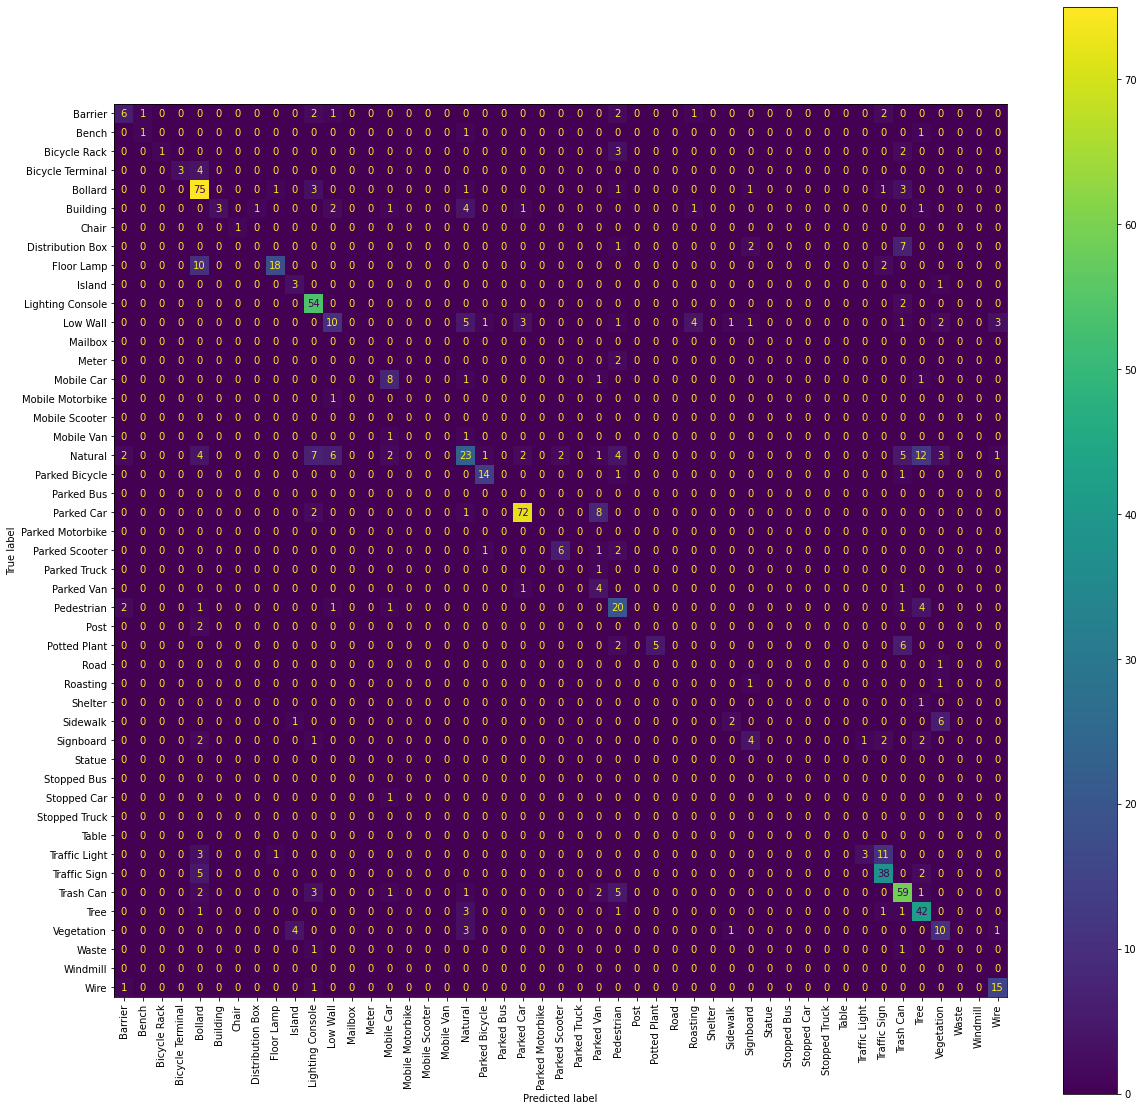

In [47]:
cm = confusion_matrix(ytestlabels, predlabels, unique_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cmd.plot(ax=ax, xticks_rotation='vertical');

plt.savefig('confusionmatrix_voxnet.png', dpi=600)

In [46]:
model_json = model.to_json()

with open('voxnet/voxnet.json', 'w') as f:
    f.write(model_json)
    
model.save_weights('voxnet/voxnet.h5')